In [3]:
import DataStructures
import Shuffle
import Plots
using DataStructures
using Shuffle
using Plots
using Random
using Distributions


#takes in an integer n
#returns array of length n of integers +/- 1 (randomly chosen) that represent spins
function initial_config(n::Int)
  config = zeros(n)
  if n%2 != 0
    println("Size n must be even.")
    return
  else
    for i=1:n
      config[i] = rand([-1, 1])
    end
  end
  #print(config)
  return config
  #essentially from N, we get a randomized array of spin ups and downs
  #e.g., N=2 may equal [1,-1]; N=4 may equal [1,-1,-1,1] as our initial configuration
end

function gaussian_rf(N)
  nd = Normal(0, 1)
  return rand(nd, N)
end

function unit_rf(N, h)
  field = zeros(N)
  for i=1:N
    field[i] = rand([-h, h])
  end
  return field
end


#standard function for getting the hamilitonian of 1/r^2
#Ising Model
function get_energy(s::AbstractArray, h::AbstractArray, J)
  E0 = 0.0
  E1 = 0.0
  E2 = 0.0
  for i=1:length(s)
    #if i != length(s)
      #E0 += J*s[i]*s[i+1]
    #else
      #E0 += J*s[i]*s[1]
    #end
    for j=i:length(s)
      if j != i
        E1 += J*(s[i]-s[j])^2/(i-j)^2
      end
    end
    E2 += h[i]*s[i]
  end
  E = -E1/2 - E2
  return E
end


#magnization equals the summation of spins in
#a configuration.
#magnetization per spin = <M>/N, where
#N is basically length of the configuration
function get_magnetization(config::AbstractArray)
  M = sum(config)
  return M
end

function get_susceptibility(M_list, Msq_list, kT, N)
  avg_M = 0
  #avg_M = sum(M_list)/mcsteps
  avg_Msq = sum(Msq_list)/mcsteps
  X = (1/kT)*(avg_Msq - avg_M^2)/N
  return X
end

function do_MC_Step(config, kT, J, h, M_list, Msq_list)
  N = length(config)
  E = get_energy(config, h, J)
  for i=1:N
    site = rand(1:N)
    config[site] = -1*config[site]
    #attempt to update one site of the configuration
    E_new = get_energy(config, h, J)
    #look at the hamiltonian of the configuration
    #given this updated site
    dE = E_new - E
    #look at the difference between old and new hamiltonian
    prob = exp(-dE/(kT))
    #Metropolis acceptance ratio
    r = rand(Float64)

    if min(1, prob) > r
     #if true, configuration is "updated"
      #accepted_states += 1
      E += dE
    else
      config[site] = -1*config[site]
      #if false, then configuration stays the same
    end
  end
  M = get_magnetization(config)
  M_sq = M^2
  #println("M squared: ", M_sq)
  #push!(M_list, abs(M))
  push!(Msq_list, M_sq)
  #we get the magnization per spin of the updated system
end


function metropolis(config_initial::AbstractArray, kT, J, h, mcsteps)
  config = copy(config_initial)
  #starts out with a configuration of randomized N spin array
  mags = Vector{Float64}()
  square_mags = Vector{Float64}()
  M = get_magnetization(config)
  push!(mags, M)
  push!(square_mags, M^2)

  accepted_states = 0
  #initial state of the configuration before a MCMC update
  E = get_energy(config, h, J)
  # hamiltonian of a particular configuration
  for i=1:mcsteps
    #For MCMC an arbitrary number steps are executed for precision
    do_MC_Step(config, kT, J, h, mags, square_mags)
    #println("MC step ", i, " at ", kT, " kT.")
  end
  return mags, square_mags
end


#CONSTANTS:

#Number of spins in initialized configuration
N = 10

#Interaction constant
J = 1.0

#Initialize number of montecarlo steps
mcsteps = 1000000

config0 = initial_config(N)

#Initialize random field(s)
h0 = zeros(N)





10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [4]:
initkT = 1.0
iter = 0.05
finalkT = 3.0



X_list1 = Vector{Float64}()
@time begin
for kT = initkT:iter:finalkT
  data = metropolis(config0, kT, J, h0, mcsteps)
  XX = get_susceptibility(data[1], data[2], kT, length(config0))
  push!(X_list1, XX)
end
plot(initkT:iter:finalkT, X_list1, xlabel = "Temperature", ylabel = "Susceptibility", linewidth = 2.5, label = "h = 0")
end
# Function to write x-y data to a text file
function write_xy_data_to_file(filename, x_data, y_data)
    open(filename, "w") do file
        for (x, y) in zip(x_data, y_data)
            write(file, string(x) * "\t" * string(y) * "\n")
        end
    end
end

# Generate x-y data
x_data = initkT:iter:finalkT
y_data = X_list1

# Write x-y data to a text file
output_file = "2nd.txt"
write_xy_data_to_file(output_file, x_data, y_data)

println("X-Y data has been written to $output_file")

 51.506181 seconds (4.35 M allocations: 636.844 MiB, 0.27% gc time, 5.20% compilation time: 24% of which was recompilation)
X-Y data has been written to 2nd.txt


In [5]:
initkT = 0
iter = 0.05
finalkT = 1

X_list2 = Vector{Float64}()
@time begin
for kT = initkT:iter:finalkT
  data = metropolis(config0, kT, J, h0, mcsteps)
  YY = get_susceptibility(data[1], data[2], kT, length(config0))
  push!(X_list2, YY)
end
# Function to write x-y data to a text file
function write_xy_data_to_file(filename, x_data, y_data)
    open(filename, "w") do file
        for (x, y) in zip(x_data, y_data)
            write(file, string(x) * "\t" * string(y) * "\n")
        end
    end
end

    plot(initkT:iter:finalkT, X_list2, xlabel = "Temperature", ylabel = "Susceptibility", linewidth = 2.5, label = "h = 0")
end

# Function to write x-y data to a text file
function write_xy_data_to_file(filename, x_data, y_data)
    open(filename, "w") do file
        for (x, y) in zip(x_data, y_data)
            write(file, string(x) * "\t" * string(y) * "\n")
        end
    end
end

# Generate x-y data
x_data = initkT:iter:finalkT
y_data = X_list2

# Write x-y data to a text file
output_file = "1sr.txt"
write_xy_data_to_file(output_file, x_data, y_data)

println("X-Y data has been written to $output_file")

 23.906743 seconds (1.04 k allocations: 205.468 MiB, 0.16% gc time)
X-Y data has been written to 1sr.txt


BoundsError: BoundsError: attempt to access 60-element StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64} at index [2:62]

 71.680966 seconds (2.03 k allocations: 596.742 MiB, 0.05% gc time)


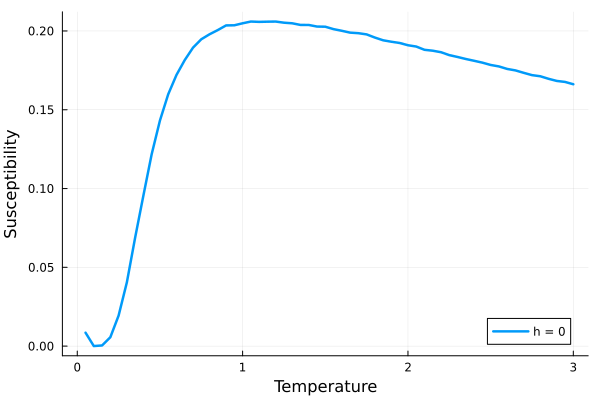

In [27]:
initkT = 0
iter = 0.05
finalkT = 3.0

X_list = Vector{Float64}()
@time begin
for kT = initkT:iter:finalkT
  data = metropolis(config0, kT, J, h0, mcsteps)
  YY = get_susceptibility(data[1], data[2], kT, length(config0))
  push!(X_list, YY)
end
plot(initkT:iter:finalkT, X_list, xlabel = "Temperature", ylabel = "Susceptibility", linewidth = 2.5, label = "h = 0")
end

In [37]:
d[2]

0.005888

In [44]:

[X_list1; X_list2][1]

Inf

In [39]:
initkT = .055
iter = 0.055
finalkT = 3.0
count = 0
X_list4 = Vector{Float64}()
X_list4 = [X_list1; X_list2]
@time begin
for kT = initkT+iter:iter:finalkT-iter
  count= count +1
  push!(X_list4, X_list4[count])
end
plot(initkT:iter:finalkT, X_list, xlabel = "Temperature", ylabel = "Susceptibility", linewidth = 2.5, label = "h = 0")
end

  0.003383 seconds (655 allocations: 53.047 KiB, 84.31% compilation time)


BoundsError: BoundsError: attempt to access 0-element Vector{Float64} at index [1:61]

In [ ]:
initkT = 0.05
iter = 0.05
finalkT = 3.0

X_list5 = Vector{Float64}()
X_list5 = [X_list]
@time begin
for kT = initkT:iter:finalkT
  data = metropolis(config0, kT, J, h0, mcsteps)
  YY = get_susceptibility(data[1], data[2], kT, length(config0))
  push!(X_list2, YY)
end
plot(initkT:iter:finalkT, X_list2, xlabel = "Temperature", ylabel = "Susceptibility", linewidth = 2.5, label = "h = 0")
end